<a href="https://colab.research.google.com/github/deepvasan02/DogsVsCats-Tensorflow/blob/main/dogs_vs_cats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Importing the necessary libraries.
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import keras
from matplotlib.image import imread
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator

In [2]:
#Loading the dataset.
train_ds, validation_ds, test_ds = tfds.load('cats_vs_dogs', split=['train[:80%]','train[80%:90%]','train[90%:100%]'], shuffle_files=True, as_supervised=True)
print('Total number of training samples: %d'%tf.data.experimental.cardinality(train_ds))
print('Total number of validation samples: %d'%tf.data.experimental.cardinality(validation_ds))
print('Total number of test samples: %d'%tf.data.experimental.cardinality(test_ds))

predict_reference=[]
predict_reference=test_ds


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete21ZOFU/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Total number of training samples: 18610
Total number of validation samples: 2326
Total number of test samples: 2326


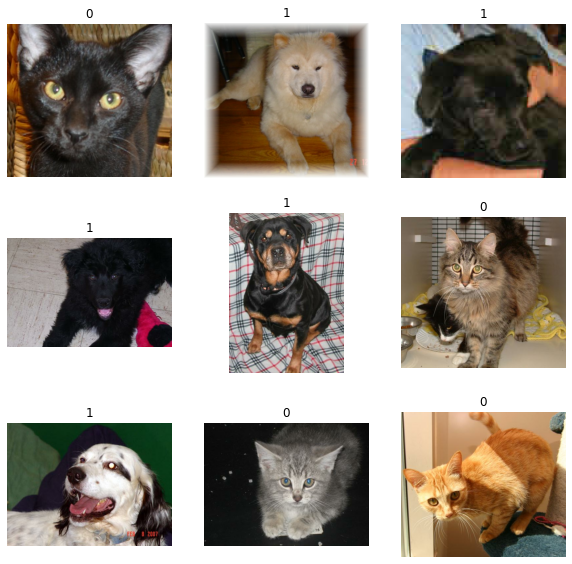

In [4]:
# Viewing sample images from training dataset :P
plt.figure(figsize=(10,10))
for i, (image,label) in enumerate(train_ds.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image)
  plt.title(int(label))
  plt.axis('off')

In [8]:
#Importing necessary tools.
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import optimizers

In [9]:
#Fixing the size of inputs.
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))



In [10]:
#Batch size
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

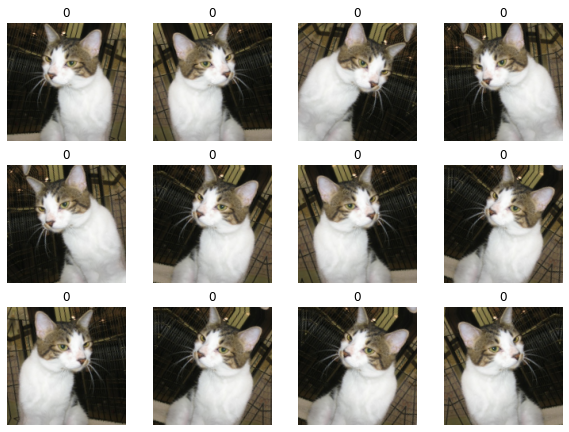

In [12]:
#Applying Augmentation to increase training size.
data_augmentation = keras.Sequential(
    [
        keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [14]:
# Creating the model
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (5,5), activation='relu', input_shape=(150, 150, 3), padding='same'))
model.add(keras.layers.MaxPooling2D((3,3)))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())


model.add(keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(keras.layers.BatchNormalization())
model.add(Dropout(0.25))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation='relu'))
model.add(keras.layers.Dense(64,activation='relu'))

# Add augmentation
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)

x = model(x, training=True)

x = keras.layers.Dropout(0.1)(x) 
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 150, 150, 3)       0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 64)                1380576   
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 1,380,641
Trainable params: 1,380,257
Non-trainable params: 384
_________________________________________________________________


In [15]:
#Training the model.
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss='binary_crossentropy', metrics=['accuracy'],
)
epochs = 50
model.fit(train_ds, epochs=epochs, validation_data=validation_ds, shuffle=True)


Epoch 1/50
582/582 [==============================] - 37s 51ms/step - loss: 0.6920 - accuracy: 0.5327 - val_loss: 0.6439 - val_accuracy: 0.6298
Epoch 2/50
582/582 [==============================] - 18s 31ms/step - loss: 0.6172 - accuracy: 0.6690 - val_loss: 0.5889 - val_accuracy: 0.6900
Epoch 3/50
582/582 [==============================] - 18s 31ms/step - loss: 0.5648 - accuracy: 0.7104 - val_loss: 0.4975 - val_accuracy: 0.7537
Epoch 4/50
582/582 [==============================] - 18s 31ms/step - loss: 0.5015 - accuracy: 0.7592 - val_loss: 0.4214 - val_accuracy: 0.8057
Epoch 5/50
582/582 [==============================] - 18s 31ms/step - loss: 0.4324 - accuracy: 0.7985 - val_loss: 0.3714 - val_accuracy: 0.8353
Epoch 6/50
582/582 [==============================] - 18s 31ms/step - loss: 0.3875 - accuracy: 0.8254 - val_loss: 0.4552 - val_accuracy: 0.7911
Epoch 7/50
582/582 [==============================] - 18s 31ms/step - loss: 0.4028 - accuracy: 0.8195 - val_loss: 0.3519 - val_accuracy:

In [16]:
#Evaluating the score of test.
score = model.evaluate(test_ds)
print("loss: ", score[0])
print("accuracy : ", score[1]*100, "%")

73/73 [==============================] - 3s 39ms/step - loss: 0.1317 - accuracy: 0.9424
loss:  0.13168765604496002
accuracy :  94.23903822898865 %


Achieved 94.2% accuracy :P

In [18]:
#Predict the test dataset.
pred = model.predict(test_ds)
classes = ['cat', 'dog']

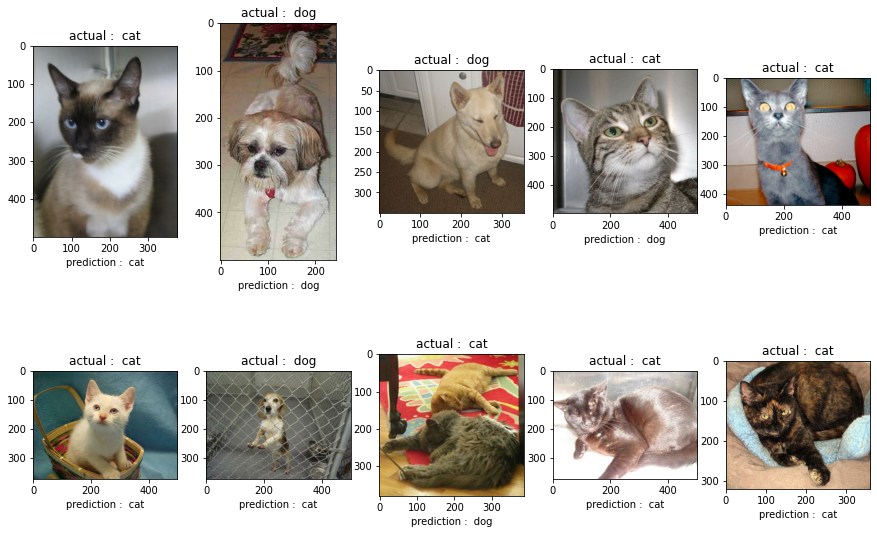

In [20]:
#Viewing the predictions.
plt.figure(figsize=(15, 20))
for i, (image, label) in enumerate(predict_reference.take(10)):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(image)
    plt.title(f"actual :  {classes[int(label)]}")
    plt.xlabel(f"prediction :  {classes[round(pred[i][0])]}")

*A few predictions went incorrect..:P

